In [149]:
import pandas as pd
df = pd.read_csv('../proposals/governor/governor_proposals.csv')
df.head()

,platform,platform_deployment_id,proposal_id,author,date,votes_count
0,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,0xec568fffba86c094cf06b22134b23074dfe2252c-110,0x55b16934c3661e1990939bc57322554d9b09f262,2022-10-19 18:10:11,124
1,governor,c0b43294-f8b9-4bbb-8a25-b5773d7b23b1,0xdbd27635a534a3d3169ef0498beb56fb9c937489-49,0x4be88f63f919324210ea3a2ccad4ff0734425f91,2023-03-08 18:29:11,98
2,governor,1a11c997-d9c2-4d3c-abe4-3d85190d02f2,0x3d5fc645320be0a085a32885f078f7121e5e5375-26,0xe8ea8bae250028a8709a3841e0ae1a44820d677b,2022-09-16 15:07:59,9
3,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,0xec568fffba86c094cf06b22134b23074dfe2252c-147,0xf71fc92e2949ccf6a5fd369a0b402ba80bc61e02,2023-01-23 10:48:11,413
4,governor,32b7bb94-fbc9-4172-9219-0ed422edf0ce,1062472272376004331395813518426159754568225993...,0x17768cfd6030e2b65eb5086e34a512fde5dc1f1f,2023-02-21 20:14:47,3


In [150]:
df.dtypes

platform                  object
platform_deployment_id    object
proposal_id               object
author                    object
date                      object
votes_count                int64
dtype: object

first lets count the votes

In [151]:
# read in votes as a duckdb and count the number of votes per proposal
import duckdb

db = duckdb.connect(database=':memory:', read_only=False)
# as view
db.execute("CREATE VIEW votes AS SELECT * FROM parquet_scan('{}')".format('../parquets_version5/votes.parquet'))

In [152]:
# write a query to select all from the proposals table and join it with a count of votes from the votes table
query = """
SELECT proposal_id as id, COUNT(*) as new_count
FROM votes
GROUP BY proposal_id
"""
proposals_with_count = db.execute(query)
proposals_with_updated_count = proposals_with_count.fetchdf()
proposals_with_updated_count.head()
# this includes governor and non-governor proposals

,id,new_count
0,3f04d1ae-ed8e-5c61-b77f-15254939c42c,1
1,c7eb5de0-a18b-59c0-aa6e-57feeef7fb3e,2
2,1c63831d-f2bf-54f0-9637-388a12e36397,2
3,502678b3-a4a1-53eb-a879-3292570f5f6e,1
4,32b97c45-714c-58b4-a49a-d0db5f81633b,15


before we can merge we need to update the proposal ids to use uuids
* id: string
* deployment_id: string
* platform_proposal_id: string (old proposal_id)

In [153]:
# rename proposal_id to platform_proposal_id
df.rename(columns={'proposal_id': 'platform_proposal_id'}, inplace=True)

* id: string
* deployment_id: string
* ~~platform_proposal_id: string (old proposal_id)~~

In [154]:
df.columns

Index(['platform', 'platform_deployment_id', 'platform_proposal_id', 'author',
       'date', 'votes_count'],
      dtype='object')

In [155]:
import uuid
df['id'] = df.apply(lambda row: str(uuid.uuid5(uuid.NAMESPACE_OID, row['platform'] + '_' + str(row['platform_deployment_id']) + '_' + str(row['platform_proposal_id']))), axis=1)

df.head()

,platform,platform_deployment_id,platform_proposal_id,author,date,votes_count,id
0,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,0xec568fffba86c094cf06b22134b23074dfe2252c-110,0x55b16934c3661e1990939bc57322554d9b09f262,2022-10-19 18:10:11,124,d5a626a1-ffde-52ea-ae01-7e601190023d
1,governor,c0b43294-f8b9-4bbb-8a25-b5773d7b23b1,0xdbd27635a534a3d3169ef0498beb56fb9c937489-49,0x4be88f63f919324210ea3a2ccad4ff0734425f91,2023-03-08 18:29:11,98,75f7c6ce-d1f1-5555-9cdb-ed0985d05413
2,governor,1a11c997-d9c2-4d3c-abe4-3d85190d02f2,0x3d5fc645320be0a085a32885f078f7121e5e5375-26,0xe8ea8bae250028a8709a3841e0ae1a44820d677b,2022-09-16 15:07:59,9,e0eb32d9-981e-5dce-bc96-1ecce11606e2
3,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,0xec568fffba86c094cf06b22134b23074dfe2252c-147,0xf71fc92e2949ccf6a5fd369a0b402ba80bc61e02,2023-01-23 10:48:11,413,c4248568-428a-5d5a-b605-b84d03128ba8
4,governor,32b7bb94-fbc9-4172-9219-0ed422edf0ce,1062472272376004331395813518426159754568225993...,0x17768cfd6030e2b65eb5086e34a512fde5dc1f1f,2023-02-21 20:14:47,3,822ce19d-ab93-52ac-9939-49c228dc5564


* ~~id: string~~
* deployment_id: string
* ~~platform_proposal_id: string (old proposal_id)~~

In [156]:
# make deployment_id
df['platform_deployment_id_to_hash'] = df.apply(lambda row: row['platform'] + '_' + str(row['platform_deployment_id']), axis=1)
df['deployment_id'] = df.apply(lambda row: str(uuid.uuid5(uuid.NAMESPACE_OID, row['platform_deployment_id_to_hash'])), axis=1)
df.head()

,platform,platform_deployment_id,platform_proposal_id,author,date,votes_count,id,platform_deployment_id_to_hash,deployment_id
0,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,0xec568fffba86c094cf06b22134b23074dfe2252c-110,0x55b16934c3661e1990939bc57322554d9b09f262,2022-10-19 18:10:11,124,d5a626a1-ffde-52ea-ae01-7e601190023d,governor_e1a6f432-bc3c-438e-a07b-ce35095de79a,cff38513-293c-55b1-862f-7b4b4fa29e5f
1,governor,c0b43294-f8b9-4bbb-8a25-b5773d7b23b1,0xdbd27635a534a3d3169ef0498beb56fb9c937489-49,0x4be88f63f919324210ea3a2ccad4ff0734425f91,2023-03-08 18:29:11,98,75f7c6ce-d1f1-5555-9cdb-ed0985d05413,governor_c0b43294-f8b9-4bbb-8a25-b5773d7b23b1,a3220258-b849-5c9c-80e2-a26096c42035
2,governor,1a11c997-d9c2-4d3c-abe4-3d85190d02f2,0x3d5fc645320be0a085a32885f078f7121e5e5375-26,0xe8ea8bae250028a8709a3841e0ae1a44820d677b,2022-09-16 15:07:59,9,e0eb32d9-981e-5dce-bc96-1ecce11606e2,governor_1a11c997-d9c2-4d3c-abe4-3d85190d02f2,6f91cad0-d222-56ae-948d-8f7c305208dd
3,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,0xec568fffba86c094cf06b22134b23074dfe2252c-147,0xf71fc92e2949ccf6a5fd369a0b402ba80bc61e02,2023-01-23 10:48:11,413,c4248568-428a-5d5a-b605-b84d03128ba8,governor_e1a6f432-bc3c-438e-a07b-ce35095de79a,cff38513-293c-55b1-862f-7b4b4fa29e5f
4,governor,32b7bb94-fbc9-4172-9219-0ed422edf0ce,1062472272376004331395813518426159754568225993...,0x17768cfd6030e2b65eb5086e34a512fde5dc1f1f,2023-02-21 20:14:47,3,822ce19d-ab93-52ac-9939-49c228dc5564,governor_32b7bb94-fbc9-4172-9219-0ed422edf0ce,b777ef1d-879e-5f51-abf5-3b6984d5add4


In [157]:
# join df and proposals_with_updated_count
df = df.merge(proposals_with_updated_count, on='id', how='left')
df.head()

,platform,platform_deployment_id,platform_proposal_id,author,date,votes_count,id,platform_deployment_id_to_hash,deployment_id,new_count
0,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,0xec568fffba86c094cf06b22134b23074dfe2252c-110,0x55b16934c3661e1990939bc57322554d9b09f262,2022-10-19 18:10:11,124,d5a626a1-ffde-52ea-ae01-7e601190023d,governor_e1a6f432-bc3c-438e-a07b-ce35095de79a,cff38513-293c-55b1-862f-7b4b4fa29e5f,120.0
1,governor,c0b43294-f8b9-4bbb-8a25-b5773d7b23b1,0xdbd27635a534a3d3169ef0498beb56fb9c937489-49,0x4be88f63f919324210ea3a2ccad4ff0734425f91,2023-03-08 18:29:11,98,75f7c6ce-d1f1-5555-9cdb-ed0985d05413,governor_c0b43294-f8b9-4bbb-8a25-b5773d7b23b1,a3220258-b849-5c9c-80e2-a26096c42035,98.0
2,governor,1a11c997-d9c2-4d3c-abe4-3d85190d02f2,0x3d5fc645320be0a085a32885f078f7121e5e5375-26,0xe8ea8bae250028a8709a3841e0ae1a44820d677b,2022-09-16 15:07:59,9,e0eb32d9-981e-5dce-bc96-1ecce11606e2,governor_1a11c997-d9c2-4d3c-abe4-3d85190d02f2,6f91cad0-d222-56ae-948d-8f7c305208dd,9.0
3,governor,e1a6f432-bc3c-438e-a07b-ce35095de79a,0xec568fffba86c094cf06b22134b23074dfe2252c-147,0xf71fc92e2949ccf6a5fd369a0b402ba80bc61e02,2023-01-23 10:48:11,413,c4248568-428a-5d5a-b605-b84d03128ba8,governor_e1a6f432-bc3c-438e-a07b-ce35095de79a,cff38513-293c-55b1-862f-7b4b4fa29e5f,404.0
4,governor,32b7bb94-fbc9-4172-9219-0ed422edf0ce,1062472272376004331395813518426159754568225993...,0x17768cfd6030e2b65eb5086e34a512fde5dc1f1f,2023-02-21 20:14:47,3,822ce19d-ab93-52ac-9939-49c228dc5564,governor_32b7bb94-fbc9-4172-9219-0ed422edf0ce,b777ef1d-879e-5f51-abf5-3b6984d5add4,3.0


In [158]:
# clean up columns
df.columns

Index(['platform', 'platform_deployment_id', 'platform_proposal_id', 'author',
       'date', 'votes_count', 'id', 'platform_deployment_id_to_hash',
       'deployment_id', 'new_count'],
      dtype='object')

compare votes count and new votes count

<Axes: xlabel='votes_count', ylabel='new_count'>

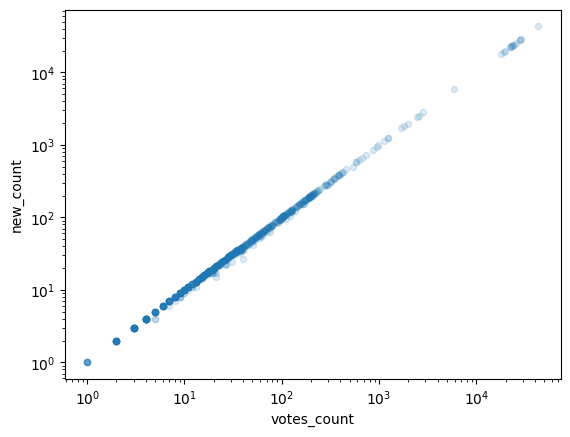

In [159]:
df.plot.scatter(x='votes_count', y='new_count', loglog=True, alpha=0.15)

In [160]:
df['votes_count'].corr(df['new_count'])

0.9999993083184247

In [161]:
# how many have a votes_count value but no new_count value?
df[(df['votes_count'] > 0) & (df['new_count'].isnull())].shape

(0, 10)

In [162]:
# drop votes_count
df.drop(columns=['votes_count'], inplace=True)
# rename new_count to votes_count
df.rename(columns={'new_count': 'votes_count'}, inplace=True)

In [163]:
df = df[[
    'id',
    'deployment_id',
    'platform_proposal_id',
    'author',
    'date',
    'votes_count',
    'platform',
]]
df.head()

,id,deployment_id,platform_proposal_id,author,date,votes_count,platform
0,d5a626a1-ffde-52ea-ae01-7e601190023d,cff38513-293c-55b1-862f-7b4b4fa29e5f,0xec568fffba86c094cf06b22134b23074dfe2252c-110,0x55b16934c3661e1990939bc57322554d9b09f262,2022-10-19 18:10:11,120.0,governor
1,75f7c6ce-d1f1-5555-9cdb-ed0985d05413,a3220258-b849-5c9c-80e2-a26096c42035,0xdbd27635a534a3d3169ef0498beb56fb9c937489-49,0x4be88f63f919324210ea3a2ccad4ff0734425f91,2023-03-08 18:29:11,98.0,governor
2,e0eb32d9-981e-5dce-bc96-1ecce11606e2,6f91cad0-d222-56ae-948d-8f7c305208dd,0x3d5fc645320be0a085a32885f078f7121e5e5375-26,0xe8ea8bae250028a8709a3841e0ae1a44820d677b,2022-09-16 15:07:59,9.0,governor
3,c4248568-428a-5d5a-b605-b84d03128ba8,cff38513-293c-55b1-862f-7b4b4fa29e5f,0xec568fffba86c094cf06b22134b23074dfe2252c-147,0xf71fc92e2949ccf6a5fd369a0b402ba80bc61e02,2023-01-23 10:48:11,404.0,governor
4,822ce19d-ab93-52ac-9939-49c228dc5564,b777ef1d-879e-5f51-abf5-3b6984d5add4,1062472272376004331395813518426159754568225993...,0x17768cfd6030e2b65eb5086e34a512fde5dc1f1f,2023-02-21 20:14:47,3.0,governor


confirm the merge with votes works ok

In [164]:
# open ../parquets_version5/deployments.parquet as pyarrow
import pyarrow.parquet as pq
deploys_df = pq.read_table('../parquets_version5/votes.parquet', columns=['id'])
deploys_df

pyarrow.Table
id: string
----
id: [["6755eb11-f57b-5841-961b-ededa4411a91","0c79521b-223f-5174-8e00-e7b96bc1b871","e9895866-0f92-5fd7-945f-3c04dd3692c1","e1aada30-aa76-57f1-85d3-9c06da614245","2de4240a-700a-5621-a09b-b57057538f2b",...,"699c5e2f-e76e-5cd5-98c5-cc724b12155a","6cacadf7-b086-5ccf-875b-7ae4fe8323eb","1f2a24e3-2439-576b-9276-8263a7e0a1de","c51b295b-067a-579d-9117-4ccc41a28928","a836fefb-3466-5d29-89e3-584a32bfb4c5"],["e3f51cfb-4958-5f9a-8439-0d7293ed6238","d8b24d9d-ef1c-582e-bad4-782fb4c781fb","12f64992-5482-5f6d-b487-42ae40465c47","2ecbf225-d7e0-5715-b17f-d0741c9ceae6","606f1946-420d-537c-a6fa-5613a7f08040",...,"5bd5e01a-0fd7-5b07-a7ce-01f8de03320c","b9dd903b-503e-578e-95e2-9580ddd598be","d58f91ac-a78c-5547-bea4-45b5e46bd17f","2eb7a5db-1d31-5164-8033-7f7a219dfa1a","a6f5f554-733e-51cd-95f3-1b51cfc22cea"],...,["deefdcd8-79f5-5937-9ba4-881cfc05ca09","dad5989f-653c-53cc-a766-5f48a0e5681c","2476193f-e383-5b44-bc26-09a6abad188f","1d7901e7-d3b2-5716-99b3-b1c46fd62385","b179c57a-f0

In [165]:
list_of_ids = df['id'].to_list()
list_of_ids[:5]

['d5a626a1-ffde-52ea-ae01-7e601190023d',
 '75f7c6ce-d1f1-5555-9cdb-ed0985d05413',
 'e0eb32d9-981e-5dce-bc96-1ecce11606e2',
 'c4248568-428a-5d5a-b605-b84d03128ba8',
 '822ce19d-ab93-52ac-9939-49c228dc5564']

In [166]:
len(list_of_ids)

740

In [167]:
df['votes_count']

0       120.0
1        98.0
2         9.0
3       404.0
4         3.0
        ...  
735       9.0
736       7.0
737    1248.0
738      22.0
739       1.0
Name: votes_count, Length: 740, dtype: float64

In [168]:
df.votes_count.sum()

414813.0

In [169]:
# make a duckdb query where id in list_of_ids, get count
import duckdb
conn = duckdb.connect(database=':memory:', read_only=False)
# filename is ../parquets_version5/votes.parquet
conn.execute("CREATE TABLE votes AS SELECT * FROM parquet_scan('../parquets_version5/votes.parquet')")
query = "SELECT count(*) FROM votes WHERE proposal_id IN ({})".format(','.join('?'*len(list_of_ids)))
conn.execute(query, list_of_ids).fetchall()

[(412714,)]

In [170]:
# fill votes_count nans with 0
df['votes_count'] = df['votes_count'].fillna(0)
# make votes_count int
df['votes_count'] = df['votes_count'].astype(int)

/var/folders/yn/b6240_995k3gl4vwtnbzzy480000gq/T/ipykernel_14944/446454408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['votes_count'] = df['votes_count'].fillna(0)
/var/folders/yn/b6240_995k3gl4vwtnbzzy480000gq/T/ipykernel_14944/446454408.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['votes_count'] = df['votes_count'].astype(int)


In [171]:
df.head()

,id,deployment_id,platform_proposal_id,author,date,votes_count,platform
0,d5a626a1-ffde-52ea-ae01-7e601190023d,cff38513-293c-55b1-862f-7b4b4fa29e5f,0xec568fffba86c094cf06b22134b23074dfe2252c-110,0x55b16934c3661e1990939bc57322554d9b09f262,2022-10-19 18:10:11,120,governor
1,75f7c6ce-d1f1-5555-9cdb-ed0985d05413,a3220258-b849-5c9c-80e2-a26096c42035,0xdbd27635a534a3d3169ef0498beb56fb9c937489-49,0x4be88f63f919324210ea3a2ccad4ff0734425f91,2023-03-08 18:29:11,98,governor
2,e0eb32d9-981e-5dce-bc96-1ecce11606e2,6f91cad0-d222-56ae-948d-8f7c305208dd,0x3d5fc645320be0a085a32885f078f7121e5e5375-26,0xe8ea8bae250028a8709a3841e0ae1a44820d677b,2022-09-16 15:07:59,9,governor
3,c4248568-428a-5d5a-b605-b84d03128ba8,cff38513-293c-55b1-862f-7b4b4fa29e5f,0xec568fffba86c094cf06b22134b23074dfe2252c-147,0xf71fc92e2949ccf6a5fd369a0b402ba80bc61e02,2023-01-23 10:48:11,404,governor
4,822ce19d-ab93-52ac-9939-49c228dc5564,b777ef1d-879e-5f51-abf5-3b6984d5add4,1062472272376004331395813518426159754568225993...,0x17768cfd6030e2b65eb5086e34a512fde5dc1f1f,2023-02-21 20:14:47,3,governor


In [172]:
import pyarrow as pa
# TODO: make proposals_table pyarrow from df
proposals_table = pa.Table.from_pandas(df, preserve_index=False)
proposals_table.schema

id: string
deployment_id: string
platform_proposal_id: string
author: string
date: string
votes_count: int64
platform: string
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 900

In [173]:
proposals_table.shape

(740, 7)

In [174]:
# read ../parquets_version4/proposals.parquet as pyarrow, print schema
pq.read_table('../parquets_version4/proposals.parquet').schema

id: string
deployment_id: string
platform_proposal_id: string
author: string
date: string
votes_count: int64
platform: string
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1089

In [175]:
import pyarrow.parquet as pq
import pyarrow as pa
from pyarrow.parquet import ParquetFile
proposals_v4_pf = ParquetFile('../parquets_version4/proposals.parquet')
for i, record_batch in enumerate(proposals_v4_pf.iter_batches(batch_size=10000)):
    # for the first chunk of records
    table = pa.Table.from_batches([record_batch])
    if i == 0:
        # create a parquet write object giving it an output file
        pqwriter = pq.ParquetWriter('../parquets_version5/proposals.parquet', table.schema)            
    pqwriter.write_table(table)

pqwriter.write_table(proposals_table)

# close the parquet writer
pqwriter.close()

In [176]:
# read '../parquets_version4/proposals.parquet' size without opening
with pq.ParquetFile('../parquets_version4/proposals.parquet') as pf:
    num_rows = pf.metadata.num_rows
    num_columns = len(pf.metadata.schema.names)
    print(f'Number of rows: {num_rows}')
    print(f'Number of columns: {num_columns}')

Number of rows: 205321
Number of columns: 7


In [177]:
# read '../parquets_version5/proposals.parquet' size without opening
with pq.ParquetFile('../parquets_version5/proposals.parquet') as pf:
    num_rows = pf.metadata.num_rows
    num_columns = len(pf.metadata.schema.names)
    print(f'Number of rows: {num_rows}')
    print(f'Number of columns: {num_columns}')

Number of rows: 206061
Number of columns: 7
